<a href="https://colab.research.google.com/github/mithril-security/blindai/blob/jupyter-0.5.0/examples/resnet18/BlindAI_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of BlindAI deployment with ResNet18

We will see in this notebook how to deploy and query a ResNet18 model on BlindAI Cloud. To upload of the model, make sure you have an API key.

You can get one on the [Mithril Cloud](https://cloud.mithrilsecurity.io/).

First, let's install `blindai`.

In [ ]:
!pip install blindai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Uploading the model to BlindAI

The first step is to get the model in ONNX format. Let's pull the ResNet18 model from PyTorch Hub and export in in ONNX.

In [ ]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# We need to provide an example of input with the right shape to export
dummy_inputs = torch.zeros(1,3,224,224)
torch.onnx.export(model, dummy_inputs, "resnet18.onnx")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Now we can upload the model to BlindAI Cloud. To upload of the model, make sure you have an API key.

You can get one on the [Mithril Cloud](https://cloud.mithrilsecurity.io/).

You might get an error if the name you want to use is already taken, as models are uniquely identified by their `model_id`. We will implement namespace soon to avoid that. Meanwhile, you will have to choose a unique ID.

In [ ]:
import blindai

api_key = "YOUR_API_KEY" # Enter your API key here

# Upload the ONNX file along with specs and model name
with blindai.Connection(api_key=api_key) as client:
    response = client.upload_model("resnet18.onnx", model_id="resnet18")

## Querying the model

Now that the model is uploaded, we just need to feed it with data. Let's first grab the image we want the model to analyze.

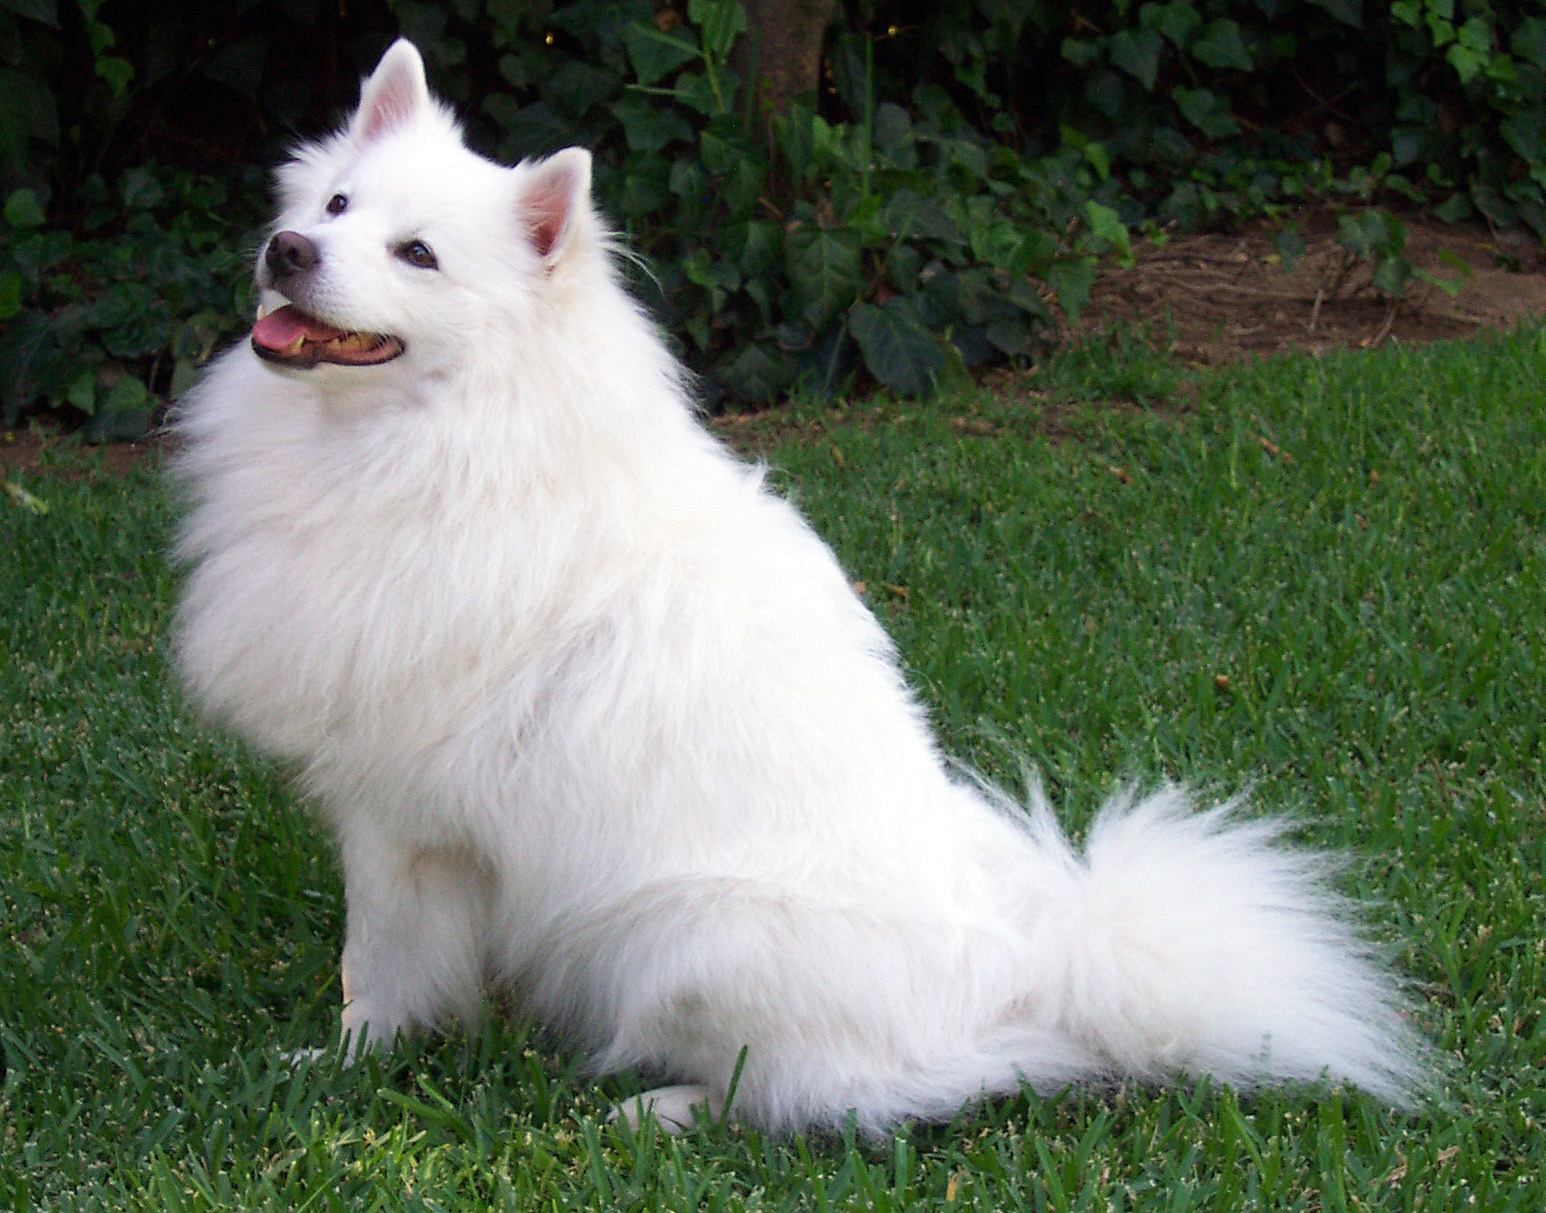

In [ ]:
from torchvision import transforms
import urllib
from PIL import Image

# Download an example image from the pytorch website
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
input_image = Image.open(filename)
input_image

We will preprocess the image to make it usable by the model.

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

Now we just need to connect to the model inside the secure enclave and query it.

In [ ]:
import blindai
import torch

with blindai.Connection(api_key=api_key) as client:
  # Send data to the ResNet18 model
  prediction = client.predict("ec3d2f13-0830-4459-a67a-f9db5e32b014", input_batch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


We can get the name of the prediction now:

In [ ]:
import requests

response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")

output = prediction.output[0].as_torch()
probabilities = torch.nn.functional.softmax(output)

labels[probabilities.argmax().item()], probabilities.max().item()

('Samoyed', 0.8846225142478943)

If you have liked this example, do not hesitate to drop a star on our [GitHub](https://github.com/mithril-security/blindai) and chat with us on our [Discord](https://discord.gg/TxEHagpWd4)!